# Lezione 17

In [ ]:
from operator import add, mul, truediv, sub

from liblet import ANTLR, AnnotatedTreeWalker, Tree

# Dal *parse tree* all' *abstract syntax tree*

Il *parse tree* è il risultato del parsing.

In [ ]:
LabeledExpr = ANTLR.load('LabeledExpr.g') # salvata in L15
LabeledExpr.print_grammar()

  1:	
  2:	grammar LabeledExpr; // rename to distinguish from Expr.g4
  3:	
  4:	prog:   stat+ ;
  5:	
  6:	stat:   expr NEWLINE                # printExpr
  7:	    |   ID '=' expr NEWLINE         # assign
  8:	    |   NEWLINE                     # blank
  9:	    ;
 10:	
 11:	expr:   expr op=('*'|'/') expr      # MulDiv
 12:	    |   expr op=('+'|'-') expr      # AddSub
 13:	    |   INT                         # int
 14:	    |   ID                          # id
 15:	    |   '(' expr ')'                # parens
 16:	    ;
 17:	
 18:	MUL :     '*' ;            // assigns token name to '*' used above in grammar
 19:	DIV :     '/' ;
 20:	ADD :     '+' ;
 21:	SUB :     '-' ;
 22:	ID  :     [a-zA-Z]+ ;      // match identifiers
 23:	INT :     [0-9]+ ;         // match integers
 24:	NEWLINE : '\r'? '\n' ;     // return newlines to parser (is end-statement signal)
 25:	WS :      [ \t]+ -> skip ; // toss out whitespace


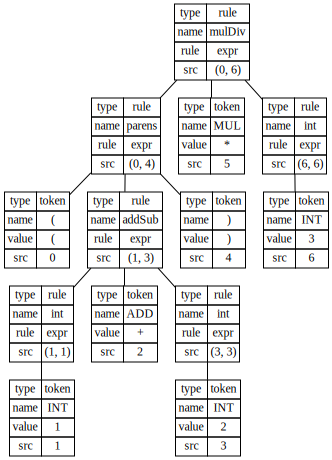

In [ ]:
# parse tree

expr = '( 1 + 2 ) * 3'
parse_tree = LabeledExpr.tree(expr, 'expr')
parse_tree

l'*AST* è un albero (annotato) che descrive più fedelmente la "semantica" che attribuiamo al linguaggio; nel caso precedente è qualcosa del genere

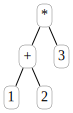

In [ ]:
Tree('*', [Tree('+', [Tree(1), Tree(2)]), Tree(3)])

## Derivazione ricorsiva (diretta)

Il modo più semplice di ottenere l'AST dal parse tree è attraverso una visita ricorsiva del medesimo. In tale visita, al solito, è molto semplice decidere cosa fare per le foglie, mentre per i nodi interni ci si può affidare alla ricorsione.

Ricordiamo che un *albero annotato* (nel senso di LibLeT) è un albero che ha per
nodi dei dizionari (`dict`); inoltre, se `tree` è un albero annotato, è
equivalmente scrivere `tree.root['key']` o `tree.attr.key` (la seconda è una
scorciatoia messa a disposizione da LibLeT).

In [ ]:
def rec_ast(tree):
  rule_name = tree.attr.name
  if rule_name in {'mulDiv', 'addSub'}:
    left, op, right = tree.children
    return Tree(
      {'type': 'op', 'kind': op.attr.name}, 
      [rec_ast(left), rec_ast(right)]
    )
  elif rule_name == 'parens':
    _, expr, _ = tree.children
    return rec_ast(expr)
  elif rule_name == 'int':
    return Tree({'type': 'const', 'value': int(tree.children[0].attr.value)})
  else:
    return Tree({'type': '<CATCHALL>'}, [rec_ast(child) for child in tree.children]) 

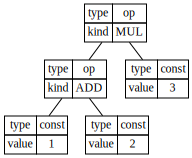

In [ ]:
abstract_syntax_tree = rec_ast(parse_tree)
abstract_syntax_tree

### <span style="color: red;">Esempio facoltativo</span>: Costruzione dell'AST durante il parsing

ANTLR mette a disposizione la possibilità di annotare la grammatica con delle "azioni" in modo tale che durante il processo stesso di parsing venga costruito l'AST.

Questo approccio (che qui è mostrato per completezza) è in realtà molto discutibile perché rende la grammatica meno "versatile" dal momento che intruduce in essa segmenti del linguaggio del runtime scelto (in questo caso Python), fatto che rende, ad esempio, la grammatica non utilizzabile con altre runtime (ad esempio Java).

L'unico possibile vantaggio di tale approccio è risparmiare memoria: l'AST è in generale più piccolo del parse tree ed inoltre, in questo modo, il parse tree non viene di fatto mai costruito esplicitamente.

In [ ]:
MulPordAST = ANTLR(r"""
grammar MulPordAST; 

@header {
from liblet import Stack 
}

@members {
    self.STACK = Stack()
}

ignoblebug: expr;

expr: expr '*' expr {self.STACK.push([{'type': 'op', 'kind': 'MUL'}, self.STACK.pop(), self.STACK.pop()])}
    | expr '+' expr {self.STACK.push([{'type': 'op', 'kind': 'ADD'}, self.STACK.pop(), self.STACK.pop()])}
    | NUM {self.STACK.push([{'type': 'const', 'value': $NUM.int}])}
    ;

NUM: [0-9]+ ;
WS: [ \t\n\r]+ -> skip ;
""")

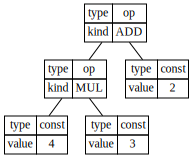

In [ ]:
ctx = MulPordAST.context('2 + 3 * 4', 'expr', build_parse_trees = False)
multprod_ast = Tree.from_lol(ctx.parser.STACK.pop())
multprod_ast

## Usando una dispatch table

Il corpo di `rec_ast` è catena di `if` basati sul valore corrispondente alla chiave `name` del nodo, con un blocco di istruzioni per ogin divera alternativa; una *dispatch table* sembra una alternativa più efficace e che consente una miglor organizzazione del codice.

In [ ]:
def dt_ast(tree):
  rule_name = tree.attr.name
  if rule_name in DISPATCH_TABLE:
    return DISPATCH_TABLE[rule_name](tree)
  else:
    return Tree({'type': '<CATCHALL>'}, [dt_ast(child) for child in tree.children]) 

Ora invece di un blocco in un `if`, a ciascuna alternativa corrisponde una funzione. La *dispatch table* servirà a mappare queste funzioni sui nodi a cui dovranno essere applicate.

In [ ]:
def visitMulDivAddSub(tree):
  left, op, right = tree.children
  return Tree(
    {'type': 'op', 'kind': op.attr.name}, 
    [dt_ast(left), dt_ast(right)]
  )

def visitParens(tree):
  _, expr, _ = tree.children
  return dt_ast(expr)

def visitInt(tree):
  return Tree({'type': 'const', 'value': int(tree.children[0].attr.value)})

In [ ]:
DISPATCH_TABLE = {
  'mulDiv': visitMulDivAddSub,
  'addSub': visitMulDivAddSub,
  'parens': visitParens,
  'int': visitInt
}

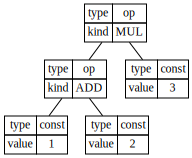

In [ ]:
dt_ast(parse_tree)

## Con un `AnnotatedTreeWalker`

L'idea di visitare un albero annotato con una funzione diversa a seconda delle caratteristiche dei nodi è così ricorrente che la libreria mette a disposizione la classe `AnnotatedTreeWalker`.

Essa consente di definire un "oggetto/funzione" che può essere invocata per visitare un albero nel modo illustrato in precedenza; per prima cosa è necessario indicare quale chiave della radice sarà usata per scegliere il da farsi e cosa fare per i casi non preneti nella *dispatch table*.

Il `TREE_CATCHALL` (che è il comportamento di default) restituisce ogni sottoalbero immutato (ma emette un *warning* così è più facile capire cosa manca dalla *dispatch table*)

In [ ]:
walker = AnnotatedTreeWalker('name', AnnotatedTreeWalker.TREE_CATCHALL)
res = walker(parse_tree)

TREE_CATCHALL: {'type': 'rule', 'name': 'mulDiv', 'rule': 'expr', 'src': (0, 6)}
TREE_CATCHALL: {'type': 'rule', 'name': 'parens', 'rule': 'expr', 'src': (0, 4)}
TREE_CATCHALL: {'type': 'token', 'name': '(', 'value': '(', 'src': 0}
TREE_CATCHALL: {'type': 'rule', 'name': 'addSub', 'rule': 'expr', 'src': (1, 3)}
TREE_CATCHALL: {'type': 'rule', 'name': 'int', 'rule': 'expr', 'src': (1, 1)}
TREE_CATCHALL: {'type': 'token', 'name': 'INT', 'value': '1', 'src': 1}
TREE_CATCHALL: {'type': 'token', 'name': 'ADD', 'value': '+', 'src': 2}
TREE_CATCHALL: {'type': 'rule', 'name': 'int', 'rule': 'expr', 'src': (3, 3)}
TREE_CATCHALL: {'type': 'token', 'name': 'INT', 'value': '2', 'src': 3}
TREE_CATCHALL: {'type': 'token', 'name': ')', 'value': ')', 'src': 4}
TREE_CATCHALL: {'type': 'token', 'name': 'MUL', 'value': '*', 'src': 5}
TREE_CATCHALL: {'type': 'rule', 'name': 'int', 'rule': 'expr', 'src': (6, 6)}
TREE_CATCHALL: {'type': 'token', 'name': 'INT', 'value': '3', 'src': 6}


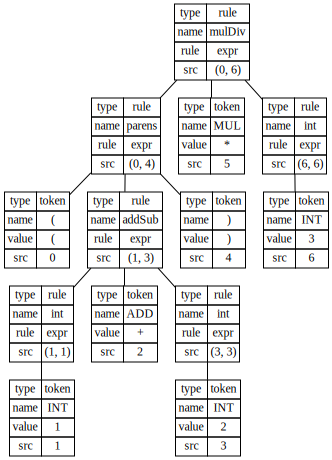

In [ ]:
res

Il `TEXT_CATCHALL` si comporta similmente, ma restituisce una stringa ottenuta componendo (con la giusta indentazione) le stringhe ottenute dai sottoalberi.

In [ ]:
walker = AnnotatedTreeWalker('name', AnnotatedTreeWalker.TEXT_CATCHALL)
res = walker(parse_tree)

TEXT_CATCHALL: {'type': 'rule', 'name': 'mulDiv', 'rule': 'expr', 'src': (0, 6)}
TEXT_CATCHALL: {'type': 'rule', 'name': 'parens', 'rule': 'expr', 'src': (0, 4)}
TEXT_CATCHALL: {'type': 'token', 'name': '(', 'value': '(', 'src': 0}
TEXT_CATCHALL: {'type': 'rule', 'name': 'addSub', 'rule': 'expr', 'src': (1, 3)}
TEXT_CATCHALL: {'type': 'rule', 'name': 'int', 'rule': 'expr', 'src': (1, 1)}
TEXT_CATCHALL: {'type': 'token', 'name': 'INT', 'value': '1', 'src': 1}
TEXT_CATCHALL: {'type': 'token', 'name': 'ADD', 'value': '+', 'src': 2}
TEXT_CATCHALL: {'type': 'rule', 'name': 'int', 'rule': 'expr', 'src': (3, 3)}
TEXT_CATCHALL: {'type': 'token', 'name': 'INT', 'value': '2', 'src': 3}
TEXT_CATCHALL: {'type': 'token', 'name': ')', 'value': ')', 'src': 4}
TEXT_CATCHALL: {'type': 'token', 'name': 'MUL', 'value': '*', 'src': 5}
TEXT_CATCHALL: {'type': 'rule', 'name': 'int', 'rule': 'expr', 'src': (6, 6)}
TEXT_CATCHALL: {'type': 'token', 'name': 'INT', 'value': '3', 'src': 6}


In [ ]:
print(res)

{'type': 'rule', 'name': 'mulDiv', 'rule': 'expr', 'src': (0, 6)}
	{'type': 'rule', 'name': 'parens', 'rule': 'expr', 'src': (0, 4)}
		{'type': 'token', 'name': '(', 'value': '(', 'src': 0}
		{'type': 'rule', 'name': 'addSub', 'rule': 'expr', 'src': (1, 3)}
			{'type': 'rule', 'name': 'int', 'rule': 'expr', 'src': (1, 1)}
				{'type': 'token', 'name': 'INT', 'value': '1', 'src': 1}
			{'type': 'token', 'name': 'ADD', 'value': '+', 'src': 2}
			{'type': 'rule', 'name': 'int', 'rule': 'expr', 'src': (3, 3)}
				{'type': 'token', 'name': 'INT', 'value': '2', 'src': 3}
		{'type': 'token', 'name': ')', 'value': ')', 'src': 4}
	{'type': 'token', 'name': 'MUL', 'value': '*', 'src': 5}
	{'type': 'rule', 'name': 'int', 'rule': 'expr', 'src': (6, 6)}
		{'type': 'token', 'name': 'INT', 'value': '3', 'src': 6}


Infine `RECOURSE_CHILDREN` effettua lo scarico ricorsivo sui sottoalberi senza emettere *warning* e senza restituire valore; questa variante tornerà utile per costruire gli interpreti ricorsivi.

In [ ]:
walker = AnnotatedTreeWalker('name', AnnotatedTreeWalker.RECOURSE_CHILDREN)
walker(parse_tree)

Per popolare la *dispatch table* basta utilizzare la stessa funzione di vista, ma questa volta come un decoratore; uniche accortezza sono che:

* il nome della funzione deve coincidere col valore della chiave di cui quella funzione dovrà occuparsi;

* ciascuna funzione riceve *due* argomenti: il primo è la funzione che rappresenta la visita del walker (necessaria per lo scarico ricorsivo), il secondo è il sottoalbero.

L'esempio seguente corrisponde a una incarnazione di `dt_ast` ottenuta come `AnnotatedTreeWalker`.

In [ ]:
atw_ast = AnnotatedTreeWalker('name')

In [ ]:
@atw_ast.register
def parens(visit, tree):
  _, expr, _ = tree.children
  return visit(expr)

@atw_ast.register
def int_(visit, tree): # il _ serve per evitare il conflitto colla funzione int
  return Tree({'type': 'const', 'value': int(tree.children[0].attr.value)})

TREE_CATCHALL: {'type': 'rule', 'name': 'mulDiv', 'rule': 'expr', 'src': (0, 6)}
TREE_CATCHALL: {'type': 'rule', 'name': 'addSub', 'rule': 'expr', 'src': (1, 3)}
TREE_CATCHALL: {'type': 'token', 'name': 'ADD', 'value': '+', 'src': 2}
TREE_CATCHALL: {'type': 'token', 'name': 'MUL', 'value': '*', 'src': 5}


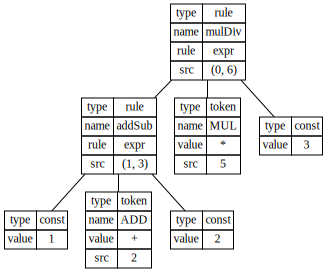

In [ ]:
atw_ast(parse_tree)

In [ ]:
def binOp(visit, tree):
  left, op, right = tree.children
  return Tree(
    {'type': 'binop', 'kind': op.attr.name}, 
    [visit(left), visit(right)]
  )

atw_ast.register(binOp, 'mulDiv')
atw_ast.register(binOp, 'addSub')

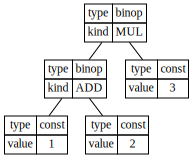

In [ ]:
atw_ast(parse_tree)

Completiamo l'opera.

In [ ]:
# atomi

@atw_ast.register
def id_(visit, tree):
  return Tree({'type': 'var', 'name': tree.children[0].attr.value})

# statement

@atw_ast.register
def blank(visit, tree):
  return None # verrà eliminato da prog

@atw_ast.register
def printExpr(visit, tree):
  expr, _ = tree.children
  return Tree({'type': 'print'}, [visit(expr)])

@atw_ast.register
def assign(visit, tree):
  name, _, expr, _ = tree.children
  return Tree({'type': 'assign', 'name': name.attr.value}, [visit(expr)])

# prog

@atw_ast.register
def prog(visit, tree):
  children = []
  for t in tree.children:
    child = visit(t)
    if child is not None: children.append(child)
  return Tree({'type': 'prog'}, children)

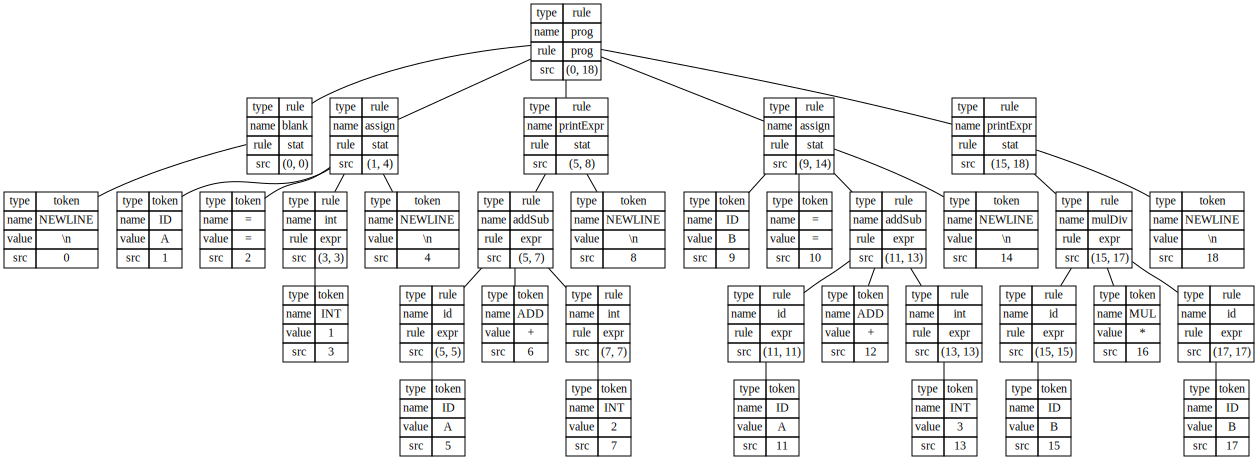

In [ ]:
prog = """
A = 1
A + 2
B = A + 3
B * B
"""

parse_tree = LabeledExpr.tree(prog, 'prog')
parse_tree

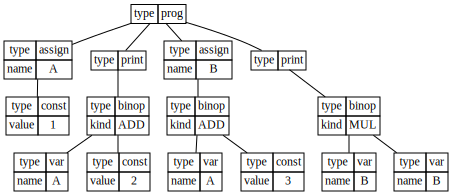

In [ ]:
abstract_syntax_tree = atw_ast(parse_tree)
abstract_syntax_tree

## Intermezzo: disfare le trasformazioni grammaticali

Recuperiamo la grammatica della lezione 13

    E  -> T + T | T
    T  -> F * F | F 
    F  -> ( E ) | i

che avevamo trasformato per evitare i conflitti `FIRST`/`FIRST` in

    E  -> T E′
    E′ -> + T E′| ε
    T  -> F F′
    F′ -> * F F′ | ε
    F  -> ( E ) | i

e convertiamola nella sintassi di ANTLR (ovvero mettiamo in minuscolo le regole *context-free* e introduciamo le regole del *lexer* per interi e *white-space*)

In [ ]:
NoConflict = ANTLR(r"""

grammar NoConflict;

x  : e; /* questo è il truccaccio per la ricorsione */

e  : t ep;

ep : '+' t ep
   | /* questa è un ε-regola */
   ; 

t  : f fp;

fp : '*' f fp 
   | /* questa è un ε-regola */
   ;
   
f  : '(' e ')' 
   | INT
   ;

INT: '0' | [1-9][0-9]*;
WS: [ \t\n\r]+ -> skip;
""")

Vediamo l'albero di parsing per una espressione "semplice"

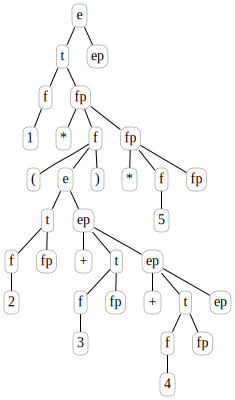

In [ ]:
text = '1 * (2 + 3 + 4) * 5'
pt = NoConflict.tree(text, 'e')
NoConflict.tree(text, 'e', True)

Come sistemarlo in modo da avere un albero "prodotto" con tre figli, di cui due costanti e un sottoalbero "somma"? 

In [ ]:
pt2ast = AnnotatedTreeWalker('name')

Iniziamo dagli *atomi*, eliminando di fatto le parentesi

In [ ]:
@pt2ast.register
def f(visit, tree):
  if len(tree.children) == 1:
    return Tree({'type': 'const', 'value': int(tree.children[0].attr.value)})
  _, expr, _ = tree.children
  return visit(expr)

Quindi gestiamo la "ricorsione" introdotta per ottenere da `fp` le ripetizioni di `* f`

In [ ]:
@pt2ast.register
def fp(visit, tree):
  if tree.children:
    _, first, rest = tree.children
    return Tree({'type': 'mul'}, [visit(first)] + visit(rest).children)
  return Tree({'type': 'mul'})

E ora da `t` possiamo ottenere il sottoalbero sinistro (se `fp` è vuoto) oppure la concatenazione

In [ ]:
@pt2ast.register
def t(visit, tree):
  f, fp = tree.children
  fp = visit(fp)
  if fp.children:
    return Tree({'type': 'mul'}, [visit(f)] + fp.children)
  return visit(f)

Per `ep` e `e` vale lo stesso ragionamento

In [ ]:
@pt2ast.register
def ep(visit, tree):
  if tree.children:
    _, first, rest = tree.children
    return Tree({'type': 'add'}, [visit(first)] + visit(rest).children)
  return Tree({'type': 'add'})

@pt2ast.register
def e(visit, tree):
  t, ep = tree.children
  ep = visit(ep)
  if ep.children:
    return Tree({'type': 'add'}, [visit(t)] + ep.children)
  return visit(t)

In fine, ecco il risultato cercato

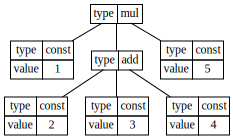

In [ ]:
pt2ast(pt)

# Esecuzione con un `AnnotatedTreeWalker`

L'approccio basato su *visitor* visto nella scorsa lezione per "eseguire" il programma può essere molto convenientemente e brevemente riscritto usanto l'*abstract syntax tree* e un apposito *walker*

In [ ]:
atw_eval = AnnotatedTreeWalker('type', AnnotatedTreeWalker.RECOURSE_CHILDREN)

MEMORY = {}

# atom

@atw_eval.register
def const(visit, tree):
  return tree.attr.value

@atw_eval.register
def var(visit, tree):
  return MEMORY.get(tree.attr.name, 0)

# op


OP_DT = {
  'ADD': add,
  'SUB': sub,
  'MUL': mul,
  'DIV': truediv 
}

@atw_eval.register
def binop(visit, tree):
  left, right = tree.children
  return OP_DT[tree.attr.kind](visit(left), visit(right))

# stat

@atw_eval.register
def print_(visit, tree):
  print(visit(tree.children[0]))

@atw_eval.register
def assign(visit, tree):
  MEMORY[tree.attr.name] = visit(tree.children[0])
    
# prog

@atw_eval.register
def prog(visit, tree):
  for child in tree.children: visit(child)

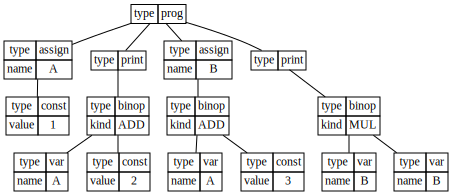

In [ ]:
abstract_syntax_tree

In [ ]:
atw_eval(abstract_syntax_tree)

3
16
